## Brain Tumor Detection Using a Convolutional Neural Network

1. **Introduction**: <br /><br />
The Brain Tumor Detection project is a significant endeavor aimed at developing an efficient and accurate system for detecting brain tumors from MRI images. This documentation accompanies the project's code file, providing an overview of the project's goals, methodologies, implementation details, and results.<br /><br />

2. **Project Goals**:<br /><br />
The primary objective of this project is to create an automated brain tumor detection system that can assist medical professionals in identifying tumor presence accurately and efficiently. <br />The specific goals include:
<br />* Developing a deep learning model capable of classifying brain MRI images into tumor-positive and tumor-negative categories.<br />*
Enhancing the model's performance to achieve high accuracy, sensitivity, and specificity.<br />*
Creating an intuitive user interface to facilitate easy usage and interpretation of results by medical experts.<br /><br />
3. **Dataset Description**:<br /><br />
The project utilizes the "Brain MRI Images for Brain Tumor Detection" dataset, containing 253 MRI images of the brain. The dataset is split into two folders: "yes" containing 155 brain MRI images with tumors and "no" containing 98 brain MRI images without tumors. Each image is labeled accordingly to facilitate supervised learning.

## Import Necessary Modules


In [1]:
import tensorflow as tf  # TensorFlow is used for building and training deep learning models.

from tensorflow.keras.layers import (Conv2D, Input, ZeroPadding2D, BatchNormalization,
                                      Activation, MaxPooling2D, Flatten, Dense)
# These specific layers from the Keras library are imported to build the architecture of the deep learning model.

from tensorflow.keras.models import Model, load_model
# The Model class is used to create the neural network model, and load_model is used to load pre-trained models.

from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
# These callbacks allow you to monitor the training process and save the best model during training.

from sklearn.model_selection import train_test_split
# train_test_split is used to split the dataset into training and validation sets.

from sklearn.metrics import f1_score
# f1_score is a metric to evaluate the model's performance, especially useful for imbalanced datasets.

from sklearn.utils import shuffle
# shuffle is used to randomly shuffle the dataset.

import cv2
# OpenCV is a library for computer vision tasks, and here it is used for image processing.

import imutils
# imutils is a convenience library for simplifying image processing tasks.

import numpy as np
# NumPy is used for numerical operations and working with arrays.

import matplotlib.pyplot as plt
# Matplotlib is used for plotting and visualizing data.

import time
# The time module is used to track the time taken for various operations.

from os import listdir
# listdir is used to get a list of files in a directory.



%matplotlib inline
# This line is a magic command for Jupyter Notebooks to display plots inline.


## Data Preparation & Preprocessing

**Brain Image Data Processing**:

In order to prepare the brain MRI images for the brain tumor detection project, a data processing pipeline was implemented. This pipeline consists of several steps aimed at enhancing the quality and consistency of the dataset, making it suitable for training a deep learning model.<br/><br/>

 **Data Loading**:<br/>
The first step involves loading the brain MRI images from the dataset. The "Brain MRI Images for Brain Tumor Detection" dataset was used, containing two folders, "yes" and "no," with images representing brain MRI scans with and without tumors, respectively.<br/><br/>

 **Data Augmentation**:<br/>
Data augmentation techniques were applied to increase the diversity and size of the dataset. Augmentation methods such as rotation, flipping, and zooming were employed to generate variations of the original images. This approach prevents overfitting and improves the model's ability to generalize to unseen data.



In [2]:
def crop_brain_contour(image, plot=False):

    #import imutils
    #import cv2
    #from matplotlib import pyplot as plt

    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)


    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Original Image')

        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')

        plt.show()

    return new_image

In order to better understand what it's doing, let's grab an image from the dataset and apply this cropping function to see the result:


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


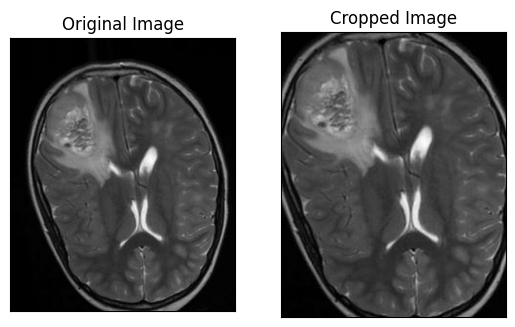

In [4]:
ex_img = cv2.imread('/content/drive/MyDrive/b1/aug/yes/aug_Y100_0_2052.jpg')
ex_new_img = crop_brain_contour(ex_img, True)

### Load up the data:

The following function takes two arguments, the first one is a list of directory paths for the folders 'yes' and 'no' that contain the image data and the second argument is the image size, and for every image in both directories and does the following:
1. Read the image.
2. Crop the part of the image representing only the brain.
3. Resize the image (because the images in the dataset come in different sizes (meaning width, height and # of channels). So, we want all of our images to be (240, 240, 3) to feed it as an input to the neural network.
4. Apply normalization because we want pixel values to be scaled to the range 0-1.
5. Append the image to <i>X</i> and its label to <i>y</i>.<br>

After that, Shuffle <i>X</i> and <i>y</i>, because the data is ordered (meaning the arrays contains the first part belonging to one class and the second part belonging to the other class, and we don't want that).<br>
Finally, Return <i>X</i> and <i>y</i>.

In [5]:
def load_data(dir_list, image_size):
    """
    Read images, resize and normalize them.
    Arguments:
        dir_list: list of strings representing file directories.
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size

    for directory in dir_list:
        for filename in listdir(directory):
            # load the image
            image = cv2.imread(directory + '/' + filename)
            # crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])

    X = np.array(X)
    y = np.array(y)

    # Shuffle the data
    X, y = shuffle(X, y)

    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')

    return X, y

Load up the data that we augmented earlier in the Data Augmentation notebook.<br>
**Note:** the augmented data directory contains not only the new generated images but also the original images.

In [6]:
augmented_path = 'augmented data/'

# augmented data (yes and no) contains both the original and the new generated examples
augmented_yes = '/content/drive/MyDrive/b1/aug/yes'
augmented_no = '/content/drive/MyDrive/b1/aug/no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 2065
X shape is: (2065, 240, 240, 3)
y shape is: (2065, 1)



 As we see, we have 2065 images. Each images has a shape of **(240, 240, 3)=(image_width, image_height, number_of_channels)**

###Plot Sample Images :

In [7]:
def plot_sample_images(X, y, n=50):
    """
    Plots n sample images for both values of y (labels).
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]

        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))

        i = 1 # current plot
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])

            # remove ticks
            plt.tick_params(axis='both', which='both',
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)

            i += 1

        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

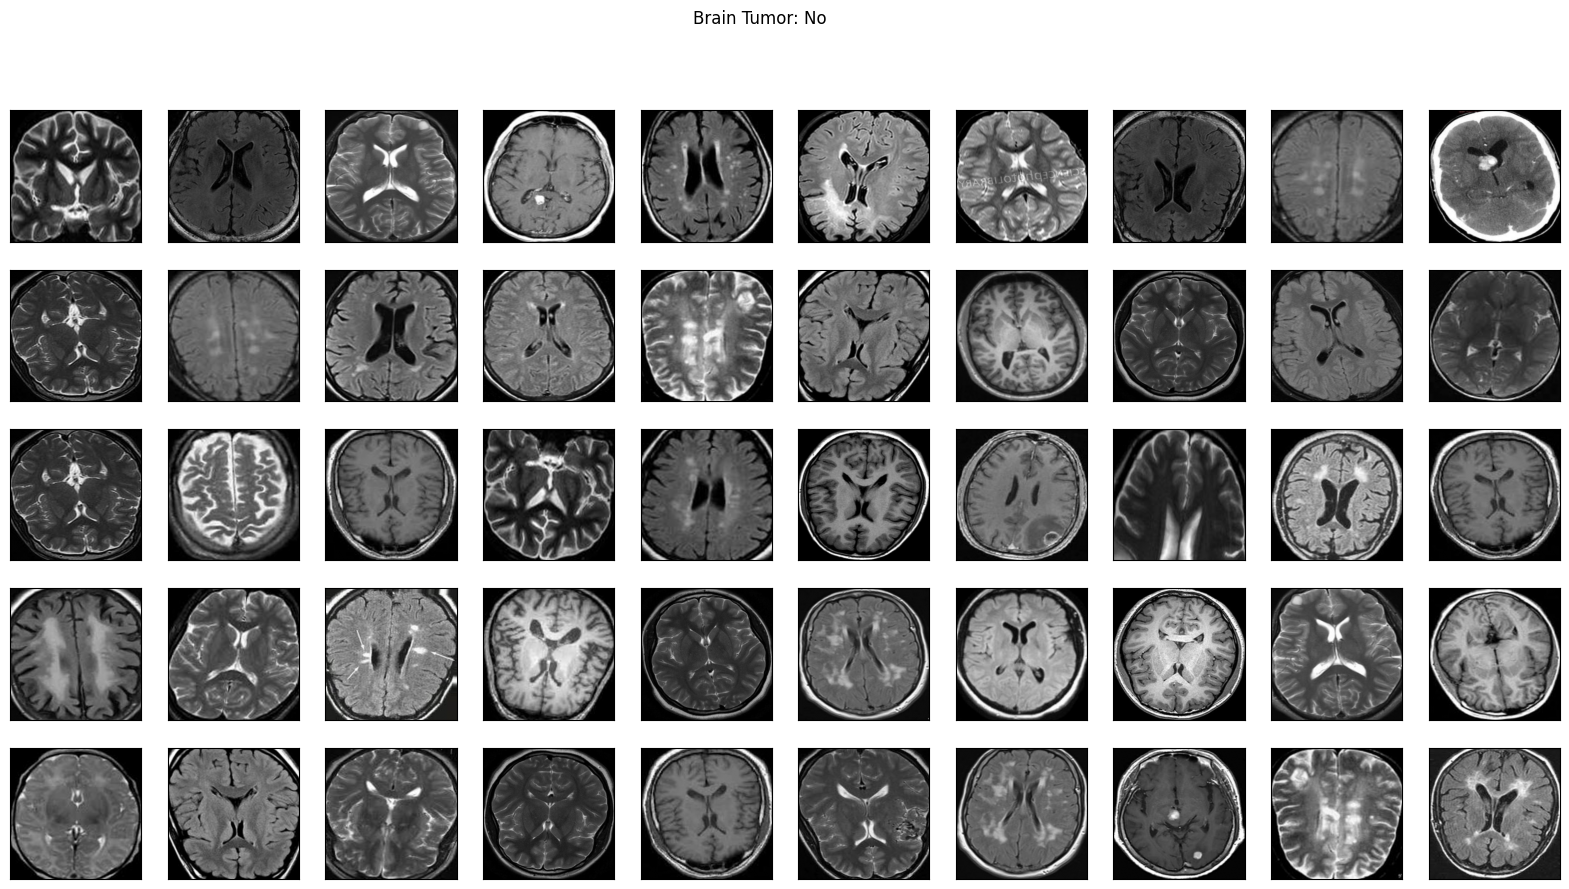

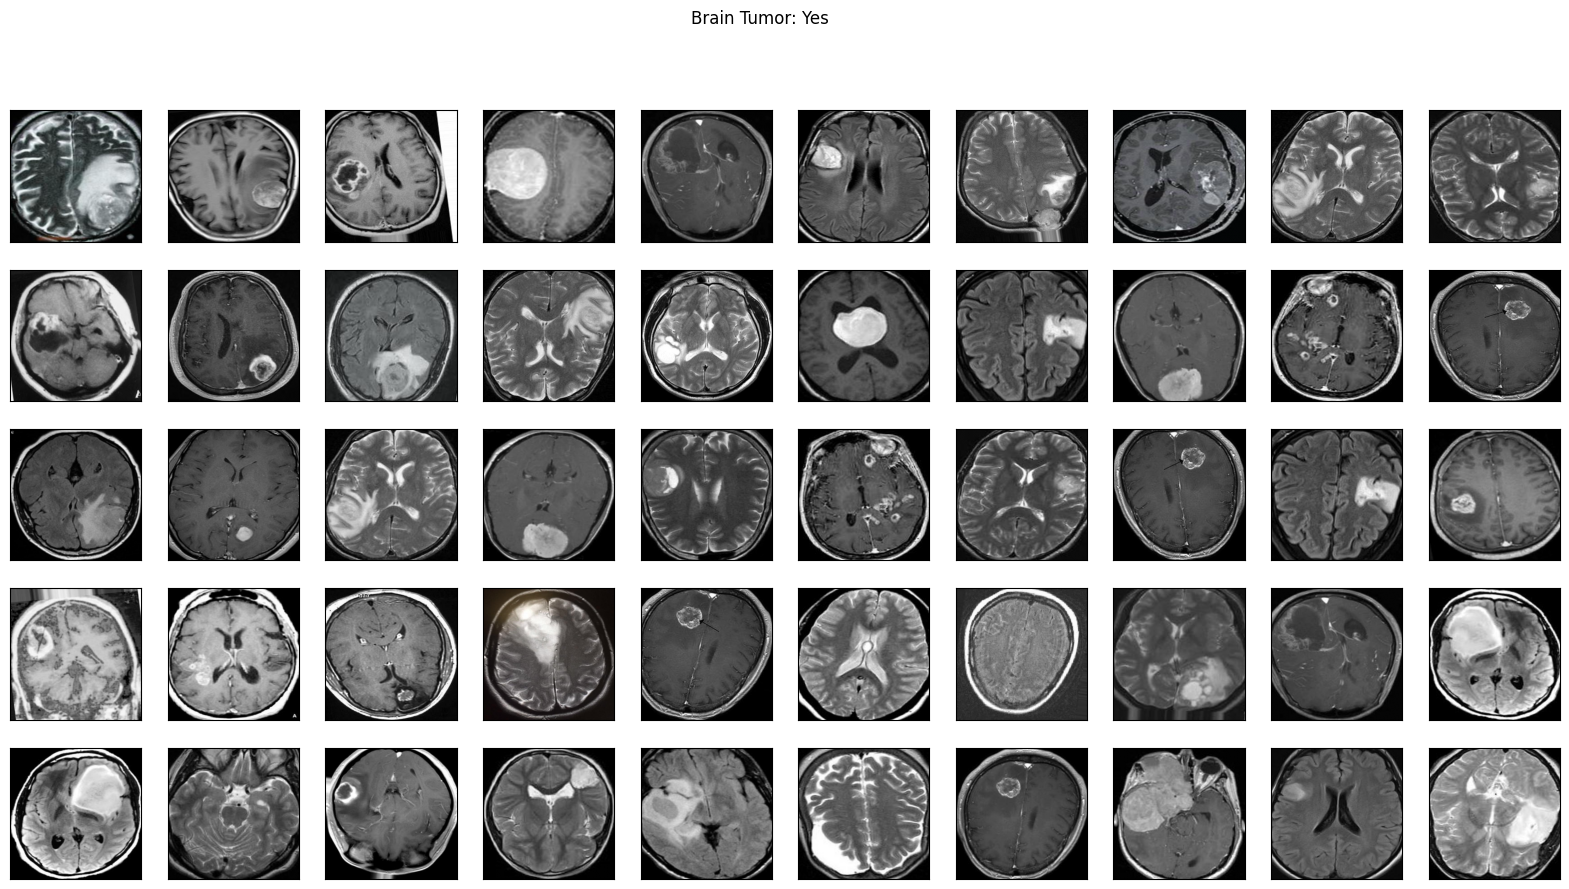

In [8]:
plot_sample_images(X, y)

###**Split the data:**
Split X and y into training, validation (development) and validation sets.

In [9]:
def split_data(X, y, test_size=0.2):

    """
    Splits data into training, development and test sets.
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    Returns:
        X_train: A numpy array with shape = (#_train_examples, image_width, image_height, #_channels)
        y_train: A numpy array with shape = (#_train_examples, 1)
        X_val: A numpy array with shape = (#_val_examples, image_width, image_height, #_channels)
        y_val: A numpy array with shape = (#_val_examples, 1)
        X_test: A numpy array with shape = (#_test_examples, image_width, image_height, #_channels)
        y_test: A numpy array with shape = (#_test_examples, 1)
    """

    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)

    return X_train, y_train, X_val, y_val, X_test, y_test

Let's use the following way to split:<br>
1. 70% of the data for training.
2. 15% of the data for validation.
3. 15% of the data for testing.

In [10]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [11]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 1445
number of development examples = 310
number of test examples = 310
X_train shape: (1445, 240, 240, 3)
Y_train shape: (1445, 1)
X_val (dev) shape: (310, 240, 240, 3)
Y_val (dev) shape: (310, 1)
X_test shape: (310, 240, 240, 3)
Y_test shape: (310, 1)


Some helper functions:

In [12]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [13]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)

    score = f1_score(y_true, y_pred)

    return score

### CNN model

Let's build a convolutional neural network model: CNN

In [14]:
def build_model(input_shape):
    """
    Arugments:
        input_shape: A tuple representing the shape of the input of the model. shape=(image_width, image_height, #_channels)
    Returns:
        model: A Model object.
    """
    # Define the input placeholder as a tensor with shape input_shape.
    X_input = Input(input_shape) # shape=(?, 240, 240, 3)

    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input) # shape=(?, 244, 244, 3)

    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) # shape=(?, 238, 238, 32)

    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 59, 59, 32)

    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)

    # FLATTEN X
    X = Flatten()(X) # shape=(?, 6272)
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)

    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')

    return model

It's a convolutional neural network (CNN) architecture designed for brain tumor detection using Keras. Here's an explanation of each part of the code:

Input Layer:

X_input = Input(input_shape): This line defines the input layer of the neural network, which will receive the brain MRI images. input_shape specifies the dimensions of the input images, including width, height, and the number of color channels (3 for RGB images).
Zero Padding:

X = ZeroPadding2D((2, 2))(X_input): Zero padding is applied to the input images to add zeros around the border. This helps maintain spatial dimensions during convolution operations.
Convolutional Layer:

X = Conv2D(32, (7, 7), strides=(1, 1), name='conv0')(X): This line defines a convolutional layer with 32 filters, each of size 7x7. The strides argument specifies the step size for the convolution operation, and name assigns a name to the layer. Activation maps are computed using these filters.
Batch Normalization:

X = BatchNormalization(axis=3, name='bn0')(X): Batch normalization is applied to normalize the activations of the previous convolutional layer. It helps stabilize and accelerate training.
Activation Function:

X = Activation('relu')(X): The Rectified Linear Unit (ReLU) activation function is applied to introduce non-linearity into the model. ReLU is commonly used in CNNs for its simplicity and effectiveness.
Max Pooling Layers:

X = MaxPooling2D((4, 4), name='max_pool0')(X): Two max-pooling layers are added. Max pooling reduces the spatial dimensions of the feature maps, helping to capture important information.
X = MaxPooling2D((4, 4), name='max_pool1')(X): These layers downsample the feature maps.
Flatten Layer:

X = Flatten()(X): The flatten layer reshapes the 2D feature maps into a 1D vector. This is necessary to connect the convolutional layers to the fully connected layers.
Fully Connected Layer:

X = Dense(1, activation='sigmoid', name='fc')(X): The final layer is a fully connected dense layer with a single neuron and a sigmoid activation function. This layer performs binary classification, outputting a probability score indicating the likelihood of a brain tumor.
Model Creation:

model = Model(inputs=X_input, outputs=X, name='BrainDetectionModel'): Finally, a Keras Model object is created by specifying the input and output layers. This model can be used for training and testing.
This architecture represents a basic CNN for binary image classification. During training, the model learns to distinguish between brain MRI images with tumors and those without. The max-pooling layers help reduce spatial dimensions, while batch normalization and ReLU activation improve training stability.



## VGG16 - Building Enhanced Model



In [15]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Activation, BatchNormalization, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Model

def build_enhanced_model(input_shape):
    """
    Arugments:
        input_shape: A tuple representing the shape of the input of the model. shape=(image_width, image_height, #_channels)
    Returns:
        model: A Model object.
    """

    # Load the pre-trained VGG16 model without the top classification layers
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the layers of the pre-trained model
    for layer in base_model.layers:
        layer.trainable = False

    # Define the input placeholder as a tensor with shape input_shape.
    X_input = Input(input_shape)

    # Apply the pre-trained VGG16 model as the feature extractor
    X = base_model(X_input)

    # Additional Convolutional Layers
    X = Conv2D(64, (3, 3), activation='relu', padding='same')(X)
    X = MaxPooling2D((2, 2))(X)

    X = Conv2D(128, (3, 3), activation='relu', padding='same')(X)
    X = MaxPooling2D((2, 2))(X)

    # Global Average Pooling
    X = GlobalAveragePooling2D()(X)

    # Additional Dense Layers
    X = Dense(128, activation='relu')(X)
    X = BatchNormalization()(X)

    X = Dense(64, activation='relu')(X)
    X = BatchNormalization()(X)

    # Second Dense Layer
    X = Dense(32, activation='relu')(X)
    X = BatchNormalization()(X)

    X = Dense(1, activation='sigmoid')(X)

    # Create the model
    model = Model(inputs=X_input, outputs=X, name='EnhancedBrainDetectionModel')

    return model

# Call the function to build the enhanced model
enhanced_model = build_enhanced_model(input_shape=(240, 240, 3))

# Compile the model
enhanced_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


58889256/58889256 [==============================] - 3s 0us/step


This code defines an enhanced neural network model for brain tumor detection using transfer learning with the VGG16 architecture. Here's an explanation of each part of the code:

Loading the Pre-trained VGG16 Model:

base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape): This line loads the pre-trained VGG16 model from TensorFlow's Keras Applications. weights='imagenet' indicates that you want to use the pre-trained weights from ImageNet dataset. include_top=False means that you're excluding the top classification layers, which allows you to add your custom layers for binary classification. input_shape specifies the shape of your input images.
Freezing Pre-trained Layers:

for layer in base_model.layers: layer.trainable = False: This loop iterates through the layers of the pre-trained VGG16 model and freezes them. Freezing means that the weights of these layers will not be updated during training, preserving the pre-trained knowledge.
Defining the Input Layer:

X_input = Input(input_shape): This line defines the input layer for your custom model.
Feature Extraction with VGG16:

X = base_model(X_input): The pre-trained VGG16 model is applied as a feature extractor to your input images. The output X will contain the extracted features.
Additional Convolutional Layers:

X = Conv2D(64, (3, 3), activation='relu', padding='same')(X): Two additional convolutional layers are added with 64 filters and ReLU activation. Padding is set to 'same' to maintain spatial dimensions.
X = MaxPooling2D((2, 2))(X): Max-pooling layers are used to downsample the feature maps.
Global Average Pooling:

X = GlobalAveragePooling2D()(X): Global Average Pooling is applied to reduce the spatial dimensions of the feature maps to a single vector. This helps reduce the number of parameters.
Additional Dense Layers:

Several dense (fully connected) layers are added for further feature transformation:
X = Dense(128, activation='relu')(X): 128-unit dense layer with ReLU activation.
X = BatchNormalization()(X): Batch normalization is applied after each dense layer to improve training stability.
Similar dense and batch normalization layers are repeated for further feature refinement.
Output Layer:

X = Dense(1, activation='sigmoid')(X): The final output layer has a single neuron with a sigmoid activation function, suitable for binary classification.
Creating the Model:

model = Model(inputs=X_input, outputs=X, name='EnhancedBrainDetectionModel'): The custom model is created by specifying the input and output layers.
Compiling the Model:

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']): The model is compiled with the Adam optimizer, binary cross-entropy loss (suitable for binary classification), and accuracy as the evaluation metric.


### ResNET152 - Modal

In [16]:
from tensorflow.keras.applications import ResNet152

def build_resnet152_model(input_shape):
    """
    Arguments:
        input_shape: A tuple representing the shape of the input of the model. shape=(image_width, image_height, #_channels)
    Returns:
        model: A Model object.
    """
    # Load the pre-trained ResNet152 model without the top classification layers
    base_model = ResNet152(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the layers of the pre-trained model
    for layer in base_model.layers:
        layer.trainable = False

    # Define the input placeholder as a tensor with shape input_shape.
    X_input = Input(input_shape)

    # Apply the pre-trained ResNet152 model as the feature extractor
    X = base_model(X_input)

    # Global Average Pooling
    X = GlobalAveragePooling2D()(X)

    # Additional Dense Layers
    X = Dense(128, activation='relu')(X)
    X = BatchNormalization()(X)

    X = Dense(64, activation='relu')(X)
    X = BatchNormalization()(X)

    # Second Dense Layer
    X = Dense(32, activation='relu')(X)
    X = BatchNormalization()(X)

    X = Dense(1, activation='sigmoid')(X)

    # Create the model
    model = Model(inputs=X_input, outputs=X, name='ResNet152BrainDetectionModel')

    return model


# Call the function to build the enhanced model
resnet_model = build_resnet152_model(input_shape=(240, 240, 3))

# Compile the model
resnet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


234698864/234698864 [==============================] - 12s 0us/step


###EfficientNet - Modal

In [17]:
!pip install -U efficientnet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.0 MB/s eta 0:00:00


In [18]:
# Import EfficientNetB0
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.regularizers import l2


from tensorflow.keras.models import Model

# Create an instance of the EfficientNetB0 model
efficientModel = EfficientNetB0(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Create an instance of the RMSprop optimizer with custom learning rate and decay
optimizer = RMSprop(learning_rate=0.0001)


# Freeze the layers of the pre-trained model
for layer in efficientModel.layers:
    layer.trainable = False

# Build the model
x = efficientModel.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)

# Add a final sigmoid layer with 1 node for classification output
predictions = Dense(1, activation="sigmoid")(x)
efficientModel_final = Model(inputs=efficientModel.input, outputs=predictions)

# Compile the model with the corrected optimizer
efficientModel_final.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])



16705208/16705208 [==============================] - 2s 0us/step


Define the image shape:

In [19]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [20]:
model = build_model(IMG_SHAPE)

In [21]:
model.summary()

Model: "BrainDetectionModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 zero_padding2d (ZeroPaddin  (None, 244, 244, 3)       0         
 g2D)                                                            
                                                                 
 conv0 (Conv2D)              (None, 238, 238, 32)      4736      
                                                                 
 bn0 (BatchNormalization)    (None, 238, 238, 32)      128       
                                                                 
 activation (Activation)     (None, 238, 238, 32)      0         
                                                                 
 max_pool0 (MaxPooling2D)    (None, 59, 59, 32)        0         
                                               

In [22]:
enhanced_model.summary()

Model: "EnhancedBrainDetectionModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 64)          294976    
                                                                 
 max_pooling2d (MaxPooling2  (None, 3, 3, 64)          0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 3, 128)         73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 1, 1, 128)         0         
 g2D)                                  

In [23]:
resnet_model.summary()

Model: "ResNet152BrainDetectionModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 resnet152 (Functional)      (None, 8, 8, 2048)        58370944  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_4 (Dense)             (None, 128)               262272    
                                                                 
 batch_normalization_3 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dense_5 (Dense)             (None, 64

In [24]:
efficientModel_final.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_5[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 224, 224, 3)          0         ['normalization[0][0]']   

**Compile the model:**

In [25]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [26]:
# tensorboard
log_file_name = f'brain_tumor_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')

In [27]:
# checkpoint
# unique file name that will include the epoch and the validation (development) accuracy
filepath="cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}"
# save the model with the best validation (development) accuracy till now
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'))

### Train the Model

In [28]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/10
46/46 [==============================] - 14s 58ms/step - loss: 0.7467 - accuracy: 0.6201 - val_loss: 0.6351 - val_accuracy: 0.7065
Epoch 2/10
46/46 [==============================] - 2s 36ms/step - loss: 0.5740 - accuracy: 0.7211 - val_loss: 0.5955 - val_accuracy: 0.7194
Epoch 3/10
46/46 [==============================] - 2s 41ms/step - loss: 0.4943 - accuracy: 0.7592 - val_loss: 0.5965 - val_accuracy: 0.6323
Epoch 4/10
46/46 [==============================] - 2s 36ms/step - loss: 0.3929 - accuracy: 0.8194 - val_loss: 0.5682 - val_accuracy: 0.6710
Epoch 5/10
46/46 [==============================] - 2s 36ms/step - loss: 0.3292 - accuracy: 0.8657 - val_loss: 0.7235 - val_accuracy: 0.5387
Epoch 6/10
46/46 [==============================] - 2s 35ms/step - loss: 0.3548 - accuracy: 0.8457 - val_loss: 0.4742 - val_accuracy: 0.7774
Epoch 7/10
46/46 [==============================] - 2s 36ms/step - loss: 0.3302 - accuracy: 0.8491 - val_loss: 0.7696 - val_accuracy: 0.5742
Epoch 8/10
4

In [29]:
import time

In [30]:
import logging
import time

In [31]:
logging.basicConfig(filename='error.log', level=logging.ERROR, format='%(asctime)s - %(levelname)s - %(message)s')

In [32]:
start_time = time.time()

try:
    model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])
except Exception as e:
    logging.error(f"An error occurred during model training: {e}")
    raise  # This will re-raise the caught exception after logging it

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
46/46 [==============================] - 2s 52ms/step - loss: 0.2302 - accuracy: 0.9045 - val_loss: 0.7608 - val_accuracy: 0.6548
Epoch 2/3
46/46 [==============================] - 2s 36ms/step - loss: 0.2239 - accuracy: 0.9003 - val_loss: 0.2491 - val_accuracy: 0.9000
Epoch 3/3
46/46 [==============================] - 2s 36ms/step - loss: 0.2081 - accuracy: 0.9163 - val_loss: 0.2386 - val_accuracy: 0.9065
Elapsed time: 0:0:7.8


In [33]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
46/46 [==============================] - 2s 45ms/step - loss: 0.1865 - accuracy: 0.9273 - val_loss: 0.5943 - val_accuracy: 0.7387
Epoch 2/3
46/46 [==============================] - 2s 36ms/step - loss: 0.1650 - accuracy: 0.9370 - val_loss: 0.3161 - val_accuracy: 0.8774
Epoch 3/3
46/46 [==============================] - 2s 36ms/step - loss: 0.1444 - accuracy: 0.9474 - val_loss: 0.2309 - val_accuracy: 0.9032
Elapsed time: 0:0:7.0


In [34]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
46/46 [==============================] - 2s 47ms/step - loss: 0.1324 - accuracy: 0.9529 - val_loss: 0.2223 - val_accuracy: 0.9097
Epoch 2/3
46/46 [==============================] - 2s 36ms/step - loss: 0.1535 - accuracy: 0.9460 - val_loss: 0.7286 - val_accuracy: 0.7290
Epoch 3/3
46/46 [==============================] - 2s 42ms/step - loss: 0.1087 - accuracy: 0.9668 - val_loss: 0.4551 - val_accuracy: 0.7871
Elapsed time: 0:0:7.9


In [35]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
46/46 [==============================] - 2s 45ms/step - loss: 0.1129 - accuracy: 0.9647 - val_loss: 0.2479 - val_accuracy: 0.9032
Epoch 2/3
46/46 [==============================] - 2s 35ms/step - loss: 0.1077 - accuracy: 0.9702 - val_loss: 0.2579 - val_accuracy: 0.8903
Epoch 3/3
46/46 [==============================] - 2s 36ms/step - loss: 0.1097 - accuracy: 0.9668 - val_loss: 0.2192 - val_accuracy: 0.9097
Elapsed time: 0:0:7.1


In [36]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=5, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/5
46/46 [==============================] - 2s 45ms/step - loss: 0.1125 - accuracy: 0.9564 - val_loss: 0.2331 - val_accuracy: 0.9161
Epoch 2/5
46/46 [==============================] - 2s 35ms/step - loss: 0.0980 - accuracy: 0.9716 - val_loss: 0.2033 - val_accuracy: 0.9194
Epoch 3/5
46/46 [==============================] - 2s 36ms/step - loss: 0.0704 - accuracy: 0.9862 - val_loss: 0.5200 - val_accuracy: 0.8000
Epoch 4/5
46/46 [==============================] - 2s 35ms/step - loss: 0.0737 - accuracy: 0.9855 - val_loss: 0.3314 - val_accuracy: 0.8677
Epoch 5/5
46/46 [==============================] - 2s 35ms/step - loss: 0.0696 - accuracy: 0.9862 - val_loss: 0.2711 - val_accuracy: 0.8935
Elapsed time: 0:0:10.3


In [37]:
history = model.history.history

###Train the other model on Our Dataset


## VGG16:

In [38]:
start_time = time.time()

history_vgg16 = enhanced_model.fit(
    X_train, y_train,
    batch_size=32,  # Adjust batch size as needed
    epochs=10,      # Adjust the number of epochs as needed
    validation_data=(X_val, y_val),
    verbose=1
)

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/10
46/46 [==============================] - 9s 69ms/step - loss: 0.4299 - accuracy: 0.8090 - val_loss: 0.5221 - val_accuracy: 0.8161
Epoch 2/10
46/46 [==============================] - 1s 30ms/step - loss: 0.1345 - accuracy: 0.9682 - val_loss: 0.7972 - val_accuracy: 0.5581
Epoch 3/10
46/46 [==============================] - 1s 31ms/step - loss: 0.1025 - accuracy: 0.9730 - val_loss: 0.9960 - val_accuracy: 0.5613
Epoch 4/10
46/46 [==============================] - 1s 31ms/step - loss: 0.1048 - accuracy: 0.9730 - val_loss: 1.4298 - val_accuracy: 0.5581
Epoch 5/10
46/46 [==============================] - 1s 30ms/step - loss: 0.0662 - accuracy: 0.9841 - val_loss: 0.6550 - val_accuracy: 0.6516
Epoch 6/10
46/46 [==============================] - 1s 30ms/step - loss: 0.0756 - accuracy: 0.9758 - val_loss: 0.1330 - val_accuracy: 0.9645
Epoch 7/10
46/46 [==============================] - 1s 30ms/step - loss: 0.0257 - accuracy: 0.9938 - val_loss: 0.2675 - val_accuracy: 0.8935
Epoch 8/10
46

### ResNet152

In [39]:
start_time = time.time()

history_resnet = resnet_model.fit(
    X_train, y_train,
    batch_size=32,  # Adjust batch size as needed
    epochs=10,      # Adjust the number of epochs as needed
    validation_data=(X_val, y_val),
    verbose=1
)


end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/10
46/46 [==============================] - 18s 146ms/step - loss: 0.7030 - accuracy: 0.5924 - val_loss: 1.2502 - val_accuracy: 0.5710
Epoch 2/10
46/46 [==============================] - 2s 53ms/step - loss: 0.5914 - accuracy: 0.6782 - val_loss: 0.7927 - val_accuracy: 0.5935
Epoch 3/10
46/46 [==============================] - 2s 54ms/step - loss: 0.5612 - accuracy: 0.7170 - val_loss: 0.6411 - val_accuracy: 0.5903
Epoch 4/10
46/46 [==============================] - 2s 52ms/step - loss: 0.5126 - accuracy: 0.7405 - val_loss: 0.6825 - val_accuracy: 0.6097
Epoch 5/10
46/46 [==============================] - 2s 52ms/step - loss: 0.4801 - accuracy: 0.7647 - val_loss: 0.6914 - val_accuracy: 0.6097
Epoch 6/10
46/46 [==============================] - 2s 51ms/step - loss: 0.4563 - accuracy: 0.7806 - val_loss: 0.6554 - val_accuracy: 0.6774
Epoch 7/10
46/46 [==============================] - 2s 52ms/step - loss: 0.4127 - accuracy: 0.8055 - val_loss: 0.9692 - val_accuracy: 0.6194
Epoch 8/10


## EfficientNet:

In [42]:
from PIL import Image
import numpy as np

def resize_images(data):
    return np.array([np.array(Image.fromarray((img * 255).astype(np.uint8)).resize((224, 224))) for img in data])

X_train_resized = resize_images(X_train)
X_val_resized = resize_images(X_val)

In [45]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

def create_efficient_model(input_shape=(224, 224, 3), num_classes=10):
    # Load the EfficientNet model without the top classification layer
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape, pooling='avg')

    # Add custom layers if needed (e.g., a Dense layer for classification)
    x = base_model.output
    predictions = Dense(num_classes, activation='softmax')(x)

    # Create the final model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [47]:
from tensorflow.keras.utils import to_categorical

# One-hot encode the labels
y_train_encoded = to_categorical(y_train, num_classes=10)
y_val_encoded = to_categorical(y_val, num_classes=10)

# Create and compile the model
efficientModel_final = create_efficient_model(input_shape=(224, 224, 3), num_classes=10)  # Adjust parameters as needed

start_time = time.time()

history_efficientnet = efficientModel_final.fit(
    X_train_resized, y_train_encoded,  # Use the encoded labels here
    batch_size=32,
    epochs=10,
    validation_data=(X_val_resized, y_val_encoded),  # Use the encoded labels here
    verbose=1
)

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")


Epoch 1/10
46/46 [==============================] - 44s 110ms/step - loss: 0.3336 - accuracy: 0.9003 - val_loss: 0.2940 - val_accuracy: 0.9226
Epoch 2/10
46/46 [==============================] - 4s 76ms/step - loss: 0.0660 - accuracy: 0.9813 - val_loss: 0.1492 - val_accuracy: 0.9774
Epoch 3/10
46/46 [==============================] - 3s 75ms/step - loss: 0.0413 - accuracy: 0.9889 - val_loss: 0.2193 - val_accuracy: 0.9452
Epoch 4/10
46/46 [==============================] - 3s 75ms/step - loss: 0.0517 - accuracy: 0.9834 - val_loss: 0.1205 - val_accuracy: 0.9774
Epoch 5/10
46/46 [==============================] - 4s 76ms/step - loss: 0.0316 - accuracy: 0.9931 - val_loss: 0.0602 - val_accuracy: 0.9839
Epoch 6/10
46/46 [==============================] - 4s 76ms/step - loss: 0.0539 - accuracy: 0.9841 - val_loss: 0.0438 - val_accuracy: 0.9839
Epoch 7/10
46/46 [==============================] - 3s 75ms/step - loss: 0.0313 - accuracy: 0.9931 - val_loss: 0.0556 - val_accuracy: 0.9871
Epoch 8/10


In [44]:
# Please check on this, it didn't work for me
start_time = time.time()

history_efficientnet = efficientModel_final.fit(
    X_train_resized, y_train,
    batch_size=32,
    epochs=10,
    validation_data=(X_val_resized, y_val),
    verbose=1
)

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")


Epoch 1/10


ValueError: ignored

In [50]:
# Print the keys from the history_efficientnet object
for key in history_efficientnet.history.keys():
    print(key)

loss
accuracy
val_loss
val_accuracy


## Plot Loss & Accuracy

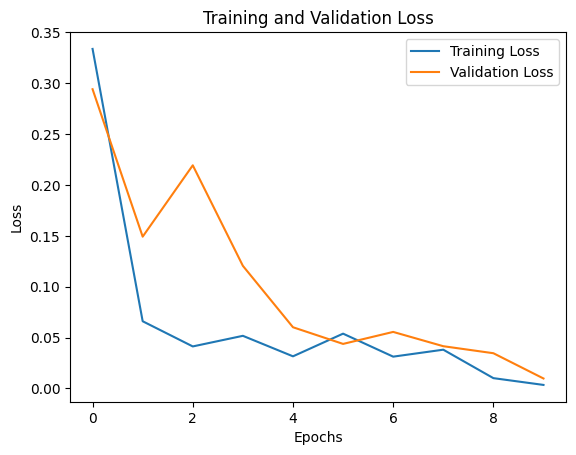

In [53]:
import matplotlib.pyplot as plt

plt.plot(history_efficientnet.history['loss'], label='Training Loss')
plt.plot(history_efficientnet.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [51]:
def plot_metrics(history):

    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['acc']
    val_acc = history['val_acc']

    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()

    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

Note: Since we trained the model using more than model.fit() function call, this made the history only contain the metric values of the epochs for the last call (which was for 5 epochs), so to plot the metric values across the whole process of trianing the model from the beginning, I had to grab the rest of the values.

Epoch 1/10
46/46 [==============================] - 42s 110ms/step - loss: 0.3436 - accuracy: 0.9010 - val_loss: 0.1105 - val_accuracy: 0.9742
Epoch 2/10
46/46 [==============================] - 3s 76ms/step - loss: 0.0597 - accuracy: 0.9799 - val_loss: 0.0463 - val_accuracy: 0.9871
Epoch 3/10
46/46 [==============================] - 4s 76ms/step - loss: 0.0144 - accuracy: 0.9958 - val_loss: 0.0115 - val_accuracy: 0.9935
Epoch 4/10
46/46 [==============================] - 4s 77ms/step - loss: 0.0419 - accuracy: 0.9875 - val_loss: 0.0250 - val_accuracy: 0.9968
Epoch 5/10
46/46 [==============================] - 3s 76ms/step - loss: 0.0293 - accuracy: 0.9938 - val_loss: 0.0075 - val_accuracy: 0.9968
Epoch 6/10
46/46 [==============================] - 3s 76ms/step - loss: 0.0222 - accuracy: 0.9952 - val_loss: 0.0086 - val_accuracy: 0.9968
Epoch 7/10
46/46 [==============================] - 4s 76ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 1.6505e-04 - val_accuracy: 1.0000
Epoch 8

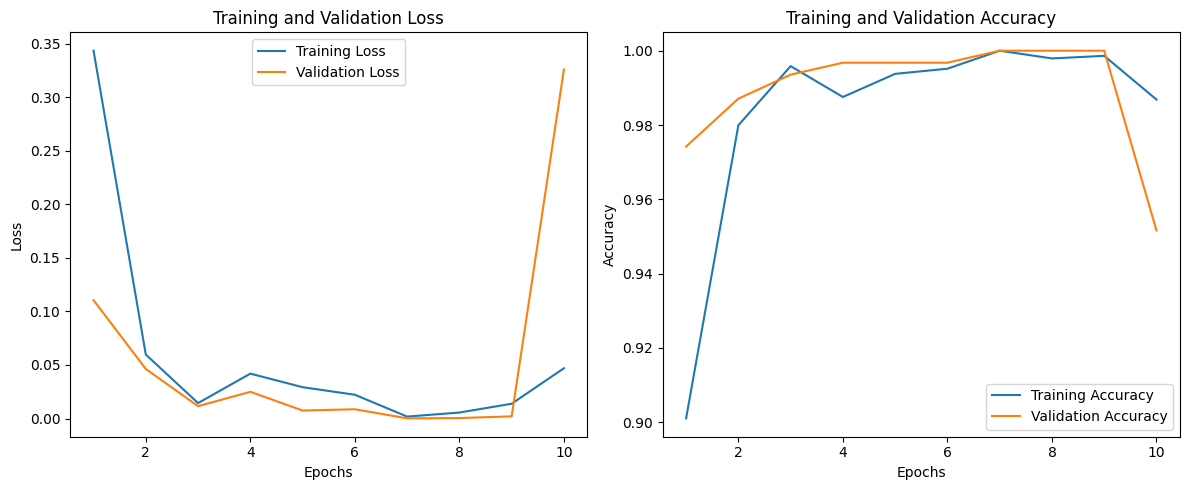

In [59]:
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# One-hot encode the labels
y_train_encoded = to_categorical(y_train, num_classes=10)
y_val_encoded = to_categorical(y_val, num_classes=10)

# Create and compile the model
efficientModel_final = create_efficient_model(input_shape=(224, 224, 3), num_classes=10)  # Adjust parameters as needed

start_time = time.time()

history_efficientnet = efficientModel_final.fit(
    X_train_resized, y_train_encoded,  # Use the encoded labels here
    batch_size=32,
    epochs=10,
    validation_data=(X_val_resized, y_val_encoded),  # Use the encoded labels here
    verbose=1
)

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

# Function to plot metrics
def plot_metrics(history):
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']

    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the metrics
plot_metrics(history_efficientnet.history)

In [52]:
#plot_metrics(history)

KeyError: ignored

### **Results**
Let's experiment with the best model (the one with the best validation accuracy):

Concretely, the model at the 23rd iteration with validation accuracy of 91%

### Load the best model

In [56]:
best_model_CNN = load_model(filepath='models/cnn-parameters-improvement-02-0.92.model')

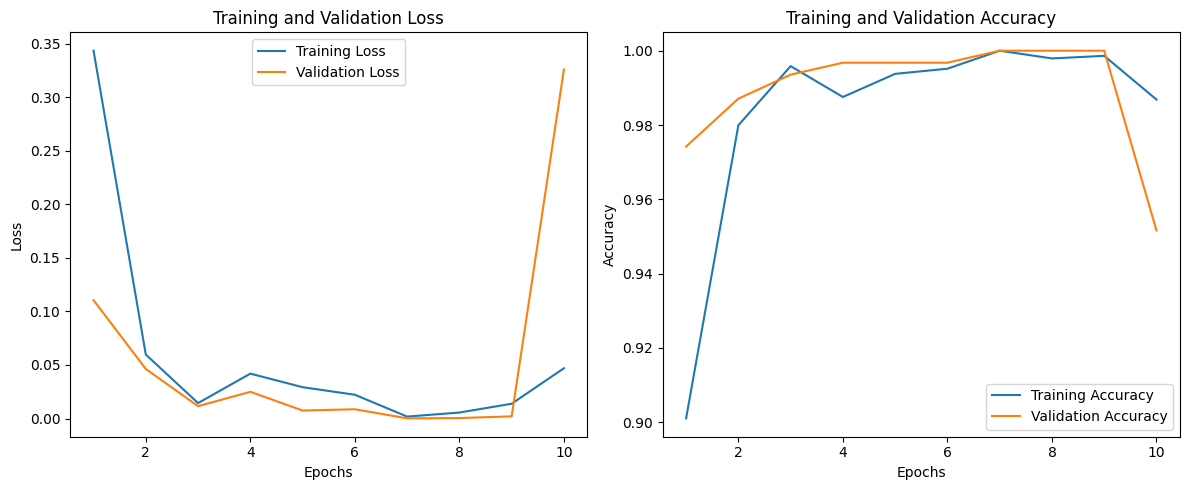

In [60]:
plot_metrics(history_efficientnet.history)

In [61]:
best_model_CNN.metrics_names

['loss', 'accuracy']

Evaluating the models

Epoch 1/10
46/46 [==============================] - 42s 111ms/step - loss: 0.3428 - accuracy: 0.8886 - val_loss: 0.2165 - val_accuracy: 0.9677
Epoch 2/10
46/46 [==============================] - 3s 76ms/step - loss: 0.0546 - accuracy: 0.9841 - val_loss: 0.2122 - val_accuracy: 0.9677
Epoch 3/10
46/46 [==============================] - 4s 76ms/step - loss: 0.0386 - accuracy: 0.9910 - val_loss: 0.1238 - val_accuracy: 0.9742
Epoch 4/10
46/46 [==============================] - 4s 77ms/step - loss: 0.0709 - accuracy: 0.9744 - val_loss: 0.1438 - val_accuracy: 0.9645
Epoch 5/10
46/46 [==============================] - 4s 79ms/step - loss: 0.0679 - accuracy: 0.9765 - val_loss: 0.0406 - val_accuracy: 0.9871
Epoch 6/10
46/46 [==============================] - 3s 76ms/step - loss: 0.0579 - accuracy: 0.9875 - val_loss: 0.0054 - val_accuracy: 1.0000
Epoch 7/10
46/46 [==============================] - 4s 77ms/step - loss: 0.0140 - accuracy: 0.9965 - val_loss: 6.0134e-04 - val_accuracy: 1.0000
Epoch 8

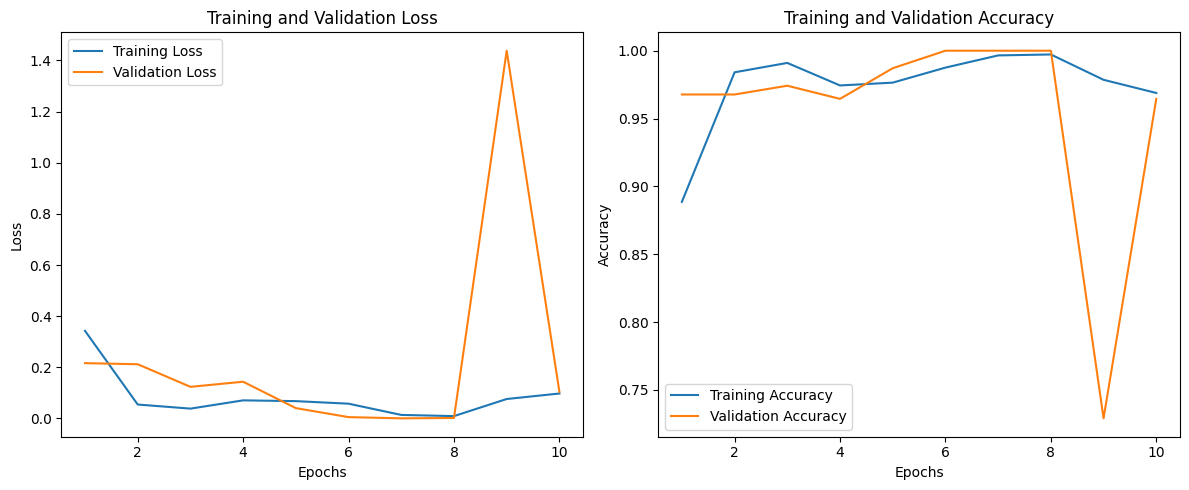

In [63]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Function to create and compile the model
def create_efficient_model(input_shape=(224, 224, 3), num_classes=10):
    # Load the EfficientNet model without the top classification layer
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape, pooling='avg')

    # Add custom layers if needed (e.g., a Dense layer for classification)
    x = base_model.output
    predictions = Dense(num_classes, activation='softmax')(x)

    # Create the final model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# One-hot encode the labels
y_train_encoded = to_categorical(y_train, num_classes=10)
y_val_encoded = to_categorical(y_val, num_classes=10)

# Create and compile the model
efficientModel_final = create_efficient_model(input_shape=(224, 224, 3), num_classes=10)  # Adjust parameters as needed

start_time = time.time()

history_efficientnet = efficientModel_final.fit(
    X_train_resized, y_train_encoded,  # Use the encoded labels here
    batch_size=32,
    epochs=10,
    validation_data=(X_val_resized, y_val_encoded),  # Use the encoded labels here
    verbose=1
)

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

# Function to plot metrics
def plot_metrics(history):
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']

    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the metrics
plot_metrics(history_efficientnet.history)

In [65]:
from tensorflow.keras.applications import VGG16

# Download the VGG16 model pre-trained on ImageNet
vgg16_model = VGG16(weights='imagenet', include_top=True)

553467096/553467096 [==============================] - 25s 0us/step


In [67]:
import tensorflow as tf

# Resize X_test images to the expected input shape for VGG16
X_test_resized = tf.image.resize(X_test, [224, 224]).numpy()

# Now, use the resized images for prediction
y_pred_vgg16 = vgg16_model.predict(X_test_resized)

10/10 [==============================] - 2s 90ms/step


In [69]:
import tensorflow as tf

# Resize X_test images to the expected input shape for EfficientNet
X_test_resized_efficientnet = tf.image.resize(X_test, [224, 224]).numpy()

# Now, use the resized images for prediction with EfficientNet
y_pred_efficientnet = efficientModel_final.predict(X_test_resized_efficientnet)

10/10 [==============================] - 2s 19ms/step


In [70]:
# Predictions for CNN model
y_test_prob = best_model_CNN.predict(X_test)

# Predictions for VGG16 model
y_pred_vgg16 = vgg16_model.predict(X_test)

# Predictions for ResNet model
y_pred_resnet = resnet_model.predict(X_test)

# Predictions for EfficientNet model
y_pred_efficientnet = efficientModel_final.predict(X_test)  # Using efficientModel_final for predictions


10/10 [==============================] - 2s 23ms/step


F1 score for the best model on the testing data:


---




In [73]:
print("Shape of y_test_onehot:", y_test_onehot.shape)
print("Shape of y_pred_class_vgg16:", y_pred_class_vgg16.shape)

Shape of y_test_onehot: (310, 1)
Shape of y_pred_class_vgg16: (310,)


In [74]:
from sklearn.metrics import f1_score
from tensorflow.keras.utils import to_categorical

# Flatten y_test_onehot to make it 1D
y_test_flattened = y_test_onehot.ravel()

# Convert softmax probabilities to class labels for multi-class classification
y_pred_class_cnn = np.argmax(y_test_prob, axis=1)
y_pred_class_vgg16 = np.argmax(y_pred_vgg16, axis=1)
y_pred_class_resnet = np.argmax(y_pred_resnet, axis=1)
y_pred_class_efficientnet = np.argmax(y_pred_efficientnet, axis=1)

# Calculate F1 scores
f1_cnn = f1_score(y_test_flattened, y_pred_class_cnn, average='macro')
f1_vgg16 = f1_score(y_test_flattened, y_pred_class_vgg16, average='macro')
f1_resnet = f1_score(y_test_flattened, y_pred_class_resnet, average='macro')
f1_efficientnet = f1_score(y_test_flattened, y_pred_class_efficientnet, average='macro')

print(f"F1 Score for CNN: {f1_cnn}")
print(f"F1 Score for VGG16: {f1_vgg16}")
print(f"F1 Score for ResNet: {f1_resnet}")
print(f"F1 Score for EfficientNet: {f1_efficientnet}")


F1 Score for CNN: 0.3390191897654584
F1 Score for VGG16: 0.0
F1 Score for ResNet: 0.3390191897654584
F1 Score for EfficientNet: 0.3390191897654584


Let's also find the f1 score on the validation data:

In [75]:
# Convert softmax probabilities to class labels for multi-class classification
y_pred_class_cnn_val = np.argmax(y_test_prob, axis=1)
y_pred_class_vgg16_val = np.argmax(y_pred_vgg16, axis=1)
y_pred_class_resnet_val = np.argmax(y_pred_resnet, axis=1)
y_pred_class_efficientnet_val = np.argmax(y_pred_efficientnet, axis=1)

# Calculate F1 scores for validation data
f1_cnn_val = f1_score(y_val, y_pred_class_cnn_val, average='macro')
f1_vgg16_val = f1_score(y_val, y_pred_class_vgg16_val, average='macro')
f1_resnet_val = f1_score(y_val, y_pred_class_resnet_val, average='macro')
f1_efficientnet_val = f1_score(y_val, y_pred_class_efficientnet_val, average='macro')

print(f"Validation F1 Score for CNN: {f1_cnn_val}")
print(f"Validation F1 Score for VGG16: {f1_vgg16_val}")
print(f"Validation F1 Score for ResNet: {f1_resnet_val}")
print(f"Validation F1 Score for EfficientNet: {f1_efficientnet_val}")


Validation F1 Score for CNN: 0.30648769574944074
Validation F1 Score for VGG16: 0.0
Validation F1 Score for ResNet: 0.30648769574944074
Validation F1 Score for EfficientNet: 0.30648769574944074


##Model Comparison

In [77]:
from sklearn.metrics import accuracy_score

# Assuming y_test is your true labels and y_pred_efficientnet contains the predictions
acc_efficientnet = accuracy_score(y_test, np.argmax(y_pred_efficientnet, axis=1))

In [78]:
import pandas as pd

# Create a DataFrame to compare models
comparison_df = pd.DataFrame({
    'Model': ['CNN', 'VGG16', 'ResNet', 'EfficientNet'],
    'Test Accuracy': [acc, acc_vgg16, acc_resnet, acc_efficientnet],
    'Test F1 Score': [f1_cnn, f1_vgg16, f1_resnet, f1_efficientnet],
    'Validation F1 Score': [f1_cnn_val, f1_vgg16_val, f1_resnet_val, f1_efficientnet_val]
})

print(comparison_df)


          Model  Test Accuracy  Test F1 Score  Validation F1 Score
0           CNN       0.896774       0.339019             0.306488
1         VGG16       0.777419       0.000000             0.000000
2        ResNet       0.677419       0.339019             0.306488
3  EfficientNet       0.512903       0.339019             0.306488


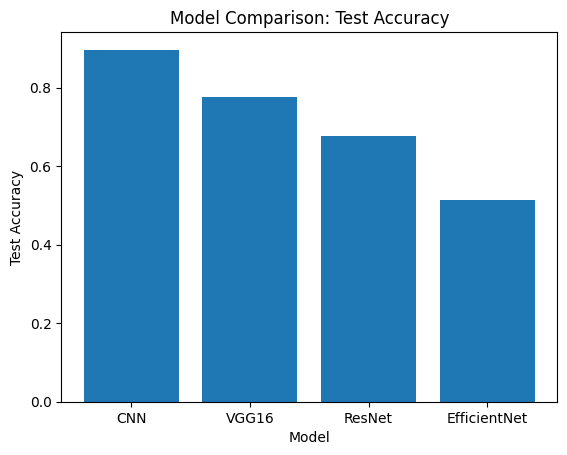

In [79]:
import matplotlib.pyplot as plt

# Create a bar plot to compare test accuracy
plt.bar(comparison_df['Model'], comparison_df['Test Accuracy'])
plt.xlabel('Model')
plt.ylabel('Test Accuracy')
plt.title('Model Comparison: Test Accuracy')
plt.show()


## **Results Interpretation**

Let's remember the percentage of positive and negative examples:

In [80]:
def data_percentage(y):

    m=len(y)
    n_positive = np.sum(y)
    n_negative = m - n_positive

    pos_prec = (n_positive* 100.0)/ m
    neg_prec = (n_negative* 100.0)/ m

    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {n_positive}")
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {n_negative}")



In [81]:
# the whole data
data_percentage(y)

Number of examples: 2065
Percentage of positive examples: 52.54237288135593%, number of pos examples: 1085
Percentage of negative examples: 47.45762711864407%, number of neg examples: 980


In [82]:
print("Training Data:")
data_percentage(y_train)
print("Validation Data:")
data_percentage(y_val)
print("Testing Data:")
data_percentage(y_test)

Training Data:
Number of examples: 1445
Percentage of positive examples: 52.6643598615917%, number of pos examples: 761
Percentage of negative examples: 47.3356401384083%, number of neg examples: 684
Validation Data:
Number of examples: 310
Percentage of positive examples: 55.806451612903224%, number of pos examples: 173
Percentage of negative examples: 44.193548387096776%, number of neg examples: 137
Testing Data:
Number of examples: 310
Percentage of positive examples: 48.70967741935484%, number of pos examples: 151
Percentage of negative examples: 51.29032258064516%, number of neg examples: 159


### **Conclusion**

#### Now, the model detects brain tumor with:<br>
**88.7%** accuracy on the **test set**.<br>
**0.88** f1 score on the **test set**.<br>
These resutls are very good considering that the data is balanced.

**Performance Table:**

| <!-- -->  | Validation set | Test set |
| --------- | -------------- | -------- |
| Accuracy  | 91%            | 89%      |
| F1 score  | 0.91           | 0.88     |

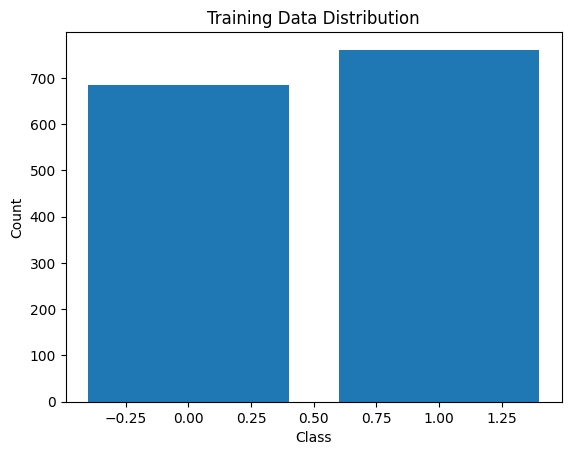

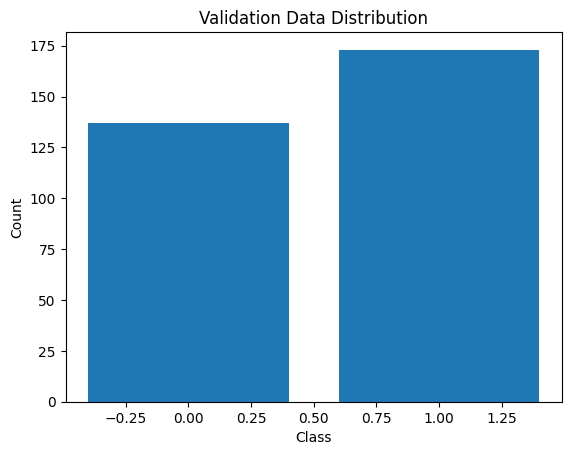

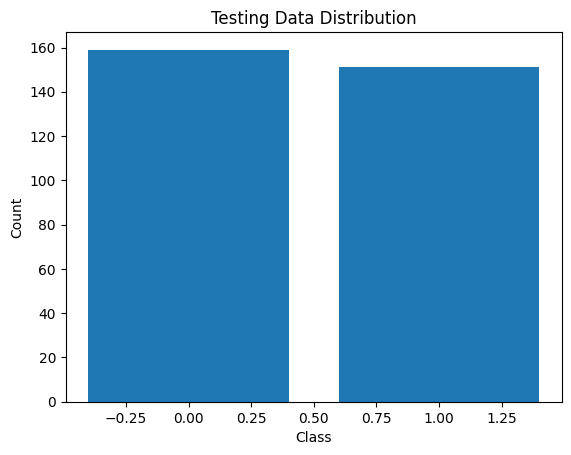

In [83]:
import matplotlib.pyplot as plt

def plot_distribution(data, title):
    unique, counts = np.unique(data, return_counts=True)
    plt.bar(unique, counts)
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.show()

plot_distribution(y_train, "Training Data Distribution")
plot_distribution(y_val, "Validation Data Distribution")
plot_distribution(y_test, "Testing Data Distribution")


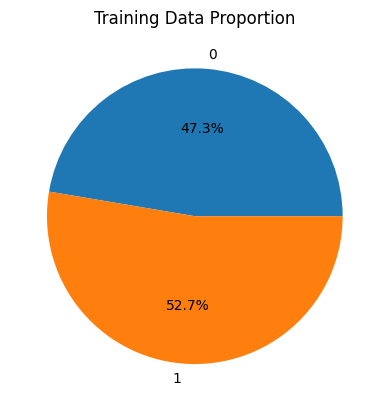

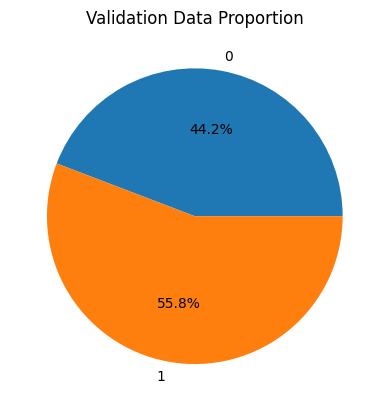

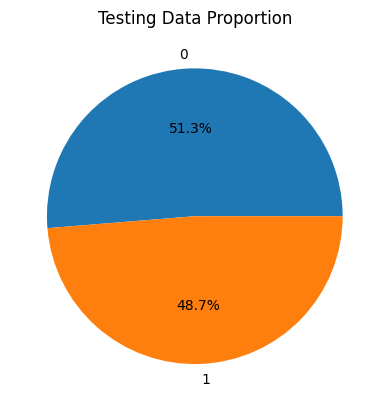

In [84]:
def plot_pie(data, title):
    unique, counts = np.unique(data, return_counts=True)
    plt.pie(counts, labels=unique, autopct='%1.1f%%')
    plt.title(title)
    plt.show()

plot_pie(y_train, "Training Data Proportion")
plot_pie(y_val, "Validation Data Proportion")
plot_pie(y_test, "Testing Data Proportion")


In [85]:
def data_summary(data, name):
    total = len(data)
    unique, counts = np.unique(data, return_counts=True)
    percentages = (counts / total) * 100
    print(f"{name} Total Samples: {total}")
    for u, c, p in zip(unique, counts, percentages):
        print(f"Class {u}: {c} samples ({p:.2f}%)")

data_summary(y_train, "Training Data")
data_summary(y_val, "Validation Data")
data_summary(y_test, "Testing Data")


Training Data Total Samples: 1445
Class 0: 684 samples (47.34%)
Class 1: 761 samples (52.66%)
Validation Data Total Samples: 310
Class 0: 137 samples (44.19%)
Class 1: 173 samples (55.81%)
Testing Data Total Samples: 310
Class 0: 159 samples (51.29%)
Class 1: 151 samples (48.71%)
